# Monitoring self-consistent field calculations

The `self_consistent_field` function takes as the `callback`
keyword argument one function to be called after each iteration.
This function gets passed the complete internal state of the SCF
solver and can thus be used both to monitor and debug the iterations
as well as to quickly patch it with additional functionality.

This example discusses a few aspects of the `callback` function
taking again our favourite silicon example.

We setup silicon in an LDA model using the ASE interface
to build the silicon lattice,
see Creating slabs with ASE for more details.

In [1]:
using DFTK
using PyCall

silicon = pyimport("ase.build").bulk("Si")
atoms = load_atoms(silicon)
atoms = [ElementPsp(el.symbol, psp=load_psp(el.symbol, functional="lda")) => position
         for (el, position) in atoms]
lattice = load_lattice(silicon);

model = model_LDA(lattice, atoms)
kgrid = [3, 3, 3]  # k-point grid
Ecut = 5           # kinetic energy cutoff in Hartree
basis = PlaneWaveBasis(model, Ecut; kgrid=kgrid)

PlaneWaveBasis (Ecut=5.0, 4 kpoints)

DFTK already defines a few callback functions for standard
tasks. One example is the usual convergence table,
which is defined in the callback `ScfDefaultCallback`.
Another example is `ScfPlotTrace`, which records the total
energy at each iteration and uses it to plot the convergence
of the SCF graphically once it is converged.
For details and other callbacks
see [src/scf/scf_callbacks.jl](https://dftk.org/blob/master/src/scf/scf_callbacks.jl).

!!! note "Callbacks are not exported"
    Callbacks are not exported from the DFTK namespace as of now,
    so you will need to use them as `DFTK.ScfDefaultCallback`
    and `DFTK.ScfPlotTrace`.

In this example we define a custom callback, which plots
the change in density at each SCF iteration after the SCF
has finished. For this we first define the empty plot canvas
and an empty container for all the density differences:

In [2]:
using Plots
p = plot(yaxis=:log)
density_differences = Float64[]

0-element Array{Float64,1}

The callback function itself gets passed a named tuple
similar to the one returned by `self_consistent_field`,
which contains the input and output density of the SCF step
as `ρin` and `ρout`. Since the callback gets called
both during the SCF iterations as well as after convergence
just before `self_consistent_field` finishes we can both
collect the data and initiate the plotting in one function.

In [3]:
using LinearAlgebra
default_callback = DFTK.ScfDefaultCallback()

function plot_callback(info)
    if info.stage == :finalize
        plot!(p, density_differences, label="|ρout - ρin|", markershape=:x)
    else
        default_callback(info)
        push!(density_differences, norm(info.ρout.real - info.ρin.real))
    end
end

plot_callback (generic function with 1 method)

Notice that we additionally made reference to the `ScfDefaultCallback`,
such that when using the `plot_callback` function with
`self_consistent_field` we still get the usual convergence table printed.
We run the SCF with this callback ...

In [4]:
scfres = self_consistent_field(basis, tol=1e-8, callback=plot_callback)

n     Energy            Eₙ-Eₙ₋₁     ρout-ρin   Diag
---   ---------------   ---------   --------   ----
  1   -7.844678456674         NaN   1.97e-01    4.3 
  2   -7.850529778457   -5.85e-03   2.91e-02    2.0 
  3   -7.850635635793   -1.06e-04   2.80e-03    1.0 
  4   -7.850646976970   -1.13e-05   6.51e-04    2.3 
  5   -7.850647493255   -5.16e-07   1.45e-04    1.8 
  6   -7.850647510938   -1.77e-08   6.37e-06    1.5 
  7   -7.850647511493   -5.55e-10   2.12e-06    3.0 


(ham = Hamiltonian(PlaneWaveBasis (Ecut=5.0, 4 kpoints), HamiltonianBlock[HamiltonianBlock(PlaneWaveBasis (Ecut=5.0, 4 kpoints), Kpoint{Float64}(:both, [0.0, 0.0, 0.0], [1, 2, 3, 17, 18, 19, 20, 21, 22, 35  …  5798, 5812, 5813, 5814, 5815, 5816, 5817, 5830, 5831, 5832], Dict(5562 => 123,633 => 53,2 => 2,5472 => 100,288 => 17,306 => 21,5220 => 97,5489 => 103,5543 => 119,360 => 39…), StaticArrays.SArray{Tuple{3},Int64,1,3}[[0, 0, 0], [1, 0, 0], [2, 0, 0], [-2, 0, 0], [-1, 0, 0], [0, 1, 0], [1, 1, 0], [2, 1, 0], [3, 1, 0], [-2, 1, 0]  …  [1, -2, -1], [-3, -2, -1], [-2, -2, -1], [-1, -2, -1], [0, -1, -1], [1, -1, -1], [2, -1, -1], [-3, -1, -1], [-2, -1, -1], [-1, -1, -1]]), DFTK.RealFourierOperator[DFTK.FourierMultiplication(PlaneWaveBasis (Ecut=5.0, 4 kpoints), Kpoint{Float64}(:both, [0.0, 0.0, 0.0], [1, 2, 3, 17, 18, 19, 20, 21, 22, 35  …  5798, 5812, 5813, 5814, 5815, 5816, 5817, 5830, 5831, 5832], Dict(5562 => 123,633 => 53,2 => 2,5472 => 100,288 => 17,306 => 21,5220 => 97,5489 => 103,

... and show the plot

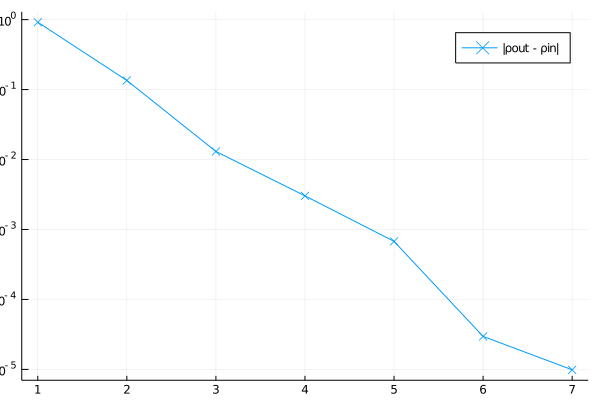

In [5]:
p

The `info` object passed to the callback contains not just the densities
but also the complete Bloch wave (in `ψ`), the `occupation`, band `eigenvalues`
and so on.
See [src/scf/self_consistent_field.jl](https://dftk.org/blob/master/src/scf/self_consistent_field.jl#L101)
for all currently available keys.

!!! tip "Debugging with callbacks"
    Very handy for debugging SCF algorithms is to employ callbacks
    with an `@infiltrate` from [Infiltrator.jl](https://github.com/JuliaDebug/Infiltrator.jl)
    to interactively monitor what is happening each SCF step.